VADER not available, installing...
Loading data...
Loaded 707 posts
Columns in posts: ['created_utc', 'title', 'ticker', 'event_date']
Sample data:
  created_utc                                              title ticker  \
0  2020-05-08       AAON board of directors addresses CEO change   AAON   
1  2020-05-17          AAON  shares down following CEO exit news   AAON   
2  2020-05-11  Portfolio impact: AAON CEO resignation affects...   AAON   
3  2020-05-07     Trading halt on AAON following CEO resignation   AAON   
4  2020-05-15       AAON board of directors addresses CEO change   AAON   

  event_date  
0 2020-05-12  
1 2020-05-12  
2 2020-05-12  
3 2020-05-12  
4 2020-05-12  
Initializing VADER sentiment analyzer...
Analyzing sentiment for posts...
Processing dates and relative days...
Sentiment analysis complete! Sample scores: {0: 443, -1: 189, 1: 75}
Performing aggregation...
Daily aggregated data shape: (527, 4)
Sample daily data:
  ticker  rel_day  sent  post_count
0   AAON   

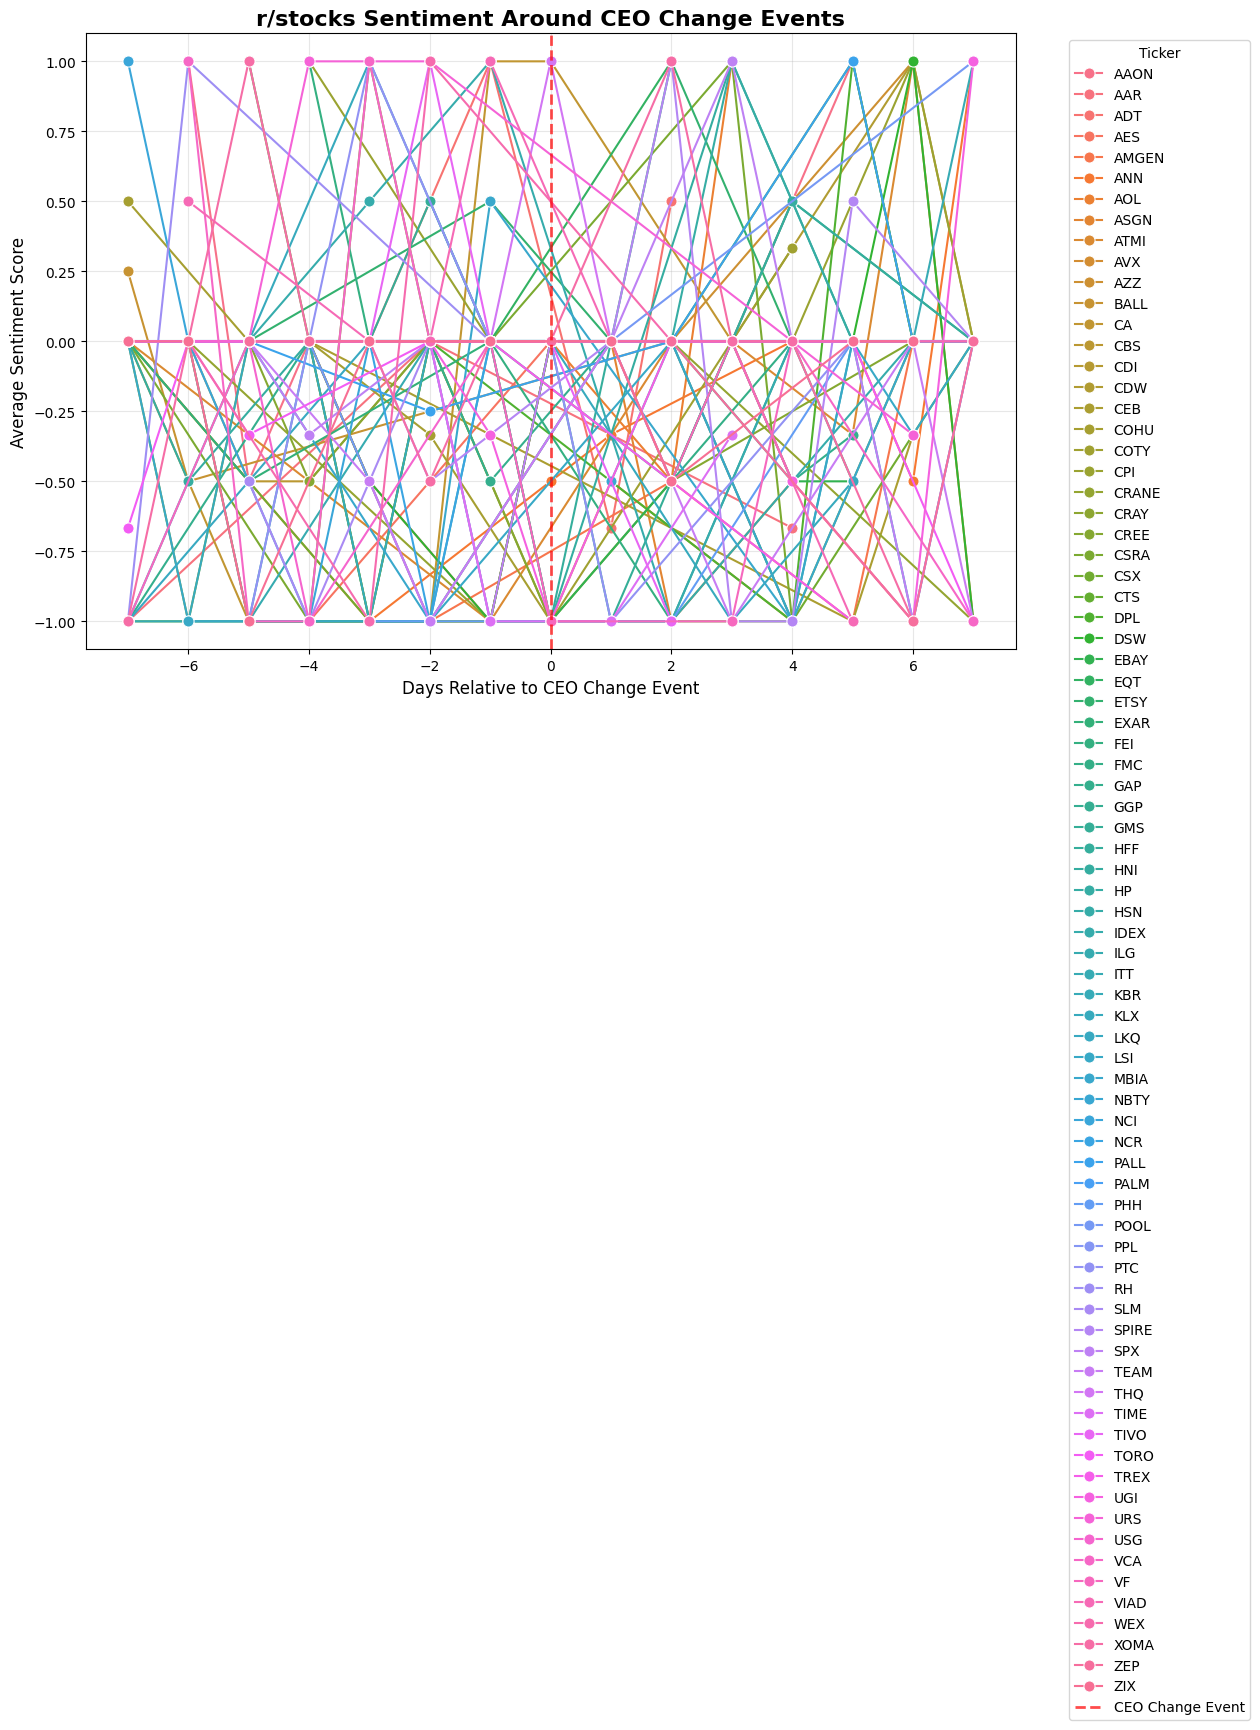


Plot saved to ../assets/sentiment_did.png

Analysis Summary:
Total posts analyzed: 707
Unique tickers: 78
Sentiment distribution: {0: 443, -1: 189, 1: 75}
Date range: 2009-12-26 00:00:00 to 2020-06-05 00:00:00
Relative day range: -7 to 7

Analysis complete!


In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from pathlib import Path
import gc
import warnings
warnings.filterwarnings('ignore')

# Use VADER sentiment instead of transformers to avoid memory issues
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    VADER_AVAILABLE = True
except ImportError:
    print("VADER not available, installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'vaderSentiment'])
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    VADER_AVAILABLE = True

print("Loading data...")
posts = pd.read_parquet("../data_raw/reddit/rstocks_posts.parquet")
print(f"Loaded {len(posts)} posts")

# Check data structure
print(f"Columns in posts: {posts.columns.tolist()}")
print(f"Sample data:\n{posts.head()}")

# Initialize VADER analyzer (much lighter and more stable)
print("Initializing VADER sentiment analyzer...")
analyzer = SentimentIntensityAnalyzer()

def score_sentiment(text):
    """Score sentiment using VADER with error handling"""
    if pd.isna(text) or text == "":
        return 0
    
    try:
        # Convert to string and limit length
        text = str(text)[:500]
        scores = analyzer.polarity_scores(text)
        
        # Use compound score and convert to -1, 0, 1 scale
        compound = scores['compound']
        if compound >= 0.05:
            return 1    # Positive
        elif compound <= -0.05:
            return -1   # Negative
        else:
            return 0    # Neutral
            
    except Exception as e:
        print(f"Error processing text: {e}")
        return 0

# Apply sentiment analysis
print("Analyzing sentiment for posts...")
posts["sent"] = posts["title"].apply(score_sentiment)

# Process dates and relative days
print("Processing dates and relative days...")
posts["created_dt"] = pd.to_datetime(posts["created_utc"]).dt.floor("D")
posts["rel_day"] = (posts["created_dt"] - posts["event_date"]).dt.days

# Save processed data
Path("../data_proc").mkdir(exist_ok=True)
posts.to_parquet("../data_proc/rstocks_scored.parquet")

print(f"Sentiment analysis complete! Sample scores: {posts['sent'].value_counts().to_dict()}")

# Check if we have valid sentiment scores
if posts['sent'].nunique() == 1 and posts['sent'].iloc[0] == 0:
    print("Warning: All sentiment scores are 0. This might indicate an issue with the text data.")
    print("Sample titles:")
    print(posts['title'].head(10).tolist())

# Aggregate data for analysis
print("Performing aggregation...")
daily = posts.groupby(["ticker", "rel_day"]).agg({
    'sent': 'mean',
    'title': 'count'  # Count posts per day
}).reset_index()
daily.columns = ['ticker', 'rel_day', 'sent', 'post_count']

print(f"Daily aggregated data shape: {daily.shape}")
print(f"Sample daily data:\n{daily.head()}")

# Create post-event indicator
daily["post"] = daily.rel_day.gt(0).astype(int)

# Filter data for regression (exclude event day)
analysis_data = daily[daily.rel_day != 0].copy()

print(f"Analysis data shape: {analysis_data.shape}")

if len(analysis_data) > 0 and analysis_data['sent'].nunique() > 1:
    try:
        print("Running Difference-in-Differences regression...")
        model = smf.ols("sent ~ post + C(ticker)", data=analysis_data).fit()
        print("\nDifference-in-Differences Results:")
        print(model.summary().tables[1])
    except Exception as e:
        print(f"Error in regression analysis: {e}")
        print("Trying simpler model without ticker fixed effects...")
        try:
            simple_model = smf.ols("sent ~ post", data=analysis_data).fit()
            print("Simple model results:")
            print(simple_model.summary().tables[1])
        except Exception as e2:
            print(f"Error in simple regression: {e2}")
else:
    print("Insufficient data variation for regression analysis")

# Create visualization
print("Creating visualization...")
plt.figure(figsize=(12, 8))

if len(daily) > 0:
    # Create plot with error handling
    try:
        sns.lineplot(data=daily, x="rel_day", y="sent", hue="ticker", marker='o', markersize=8)
        plt.axvline(0, ls="--", color='red', alpha=0.7, linewidth=2, label='CEO Change Event')
        plt.title("r/stocks Sentiment Around CEO Change Events", fontsize=16, fontweight='bold')
        plt.xlabel("Days Relative to CEO Change Event", fontsize=12)
        plt.ylabel("Average Sentiment Score", fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Improve legend
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, title="Ticker", bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        
        # Save plot
        Path("../assets").mkdir(exist_ok=True)
        plt.savefig("../assets/sentiment_did.png", dpi=160, bbox_inches='tight')
        plt.show()
        
        print(f"\nPlot saved to ../assets/sentiment_did.png")
        
    except Exception as e:
        print(f"Error creating plot: {e}")
        plt.close()
else:
    print("No data available for plotting")

# Summary statistics
print(f"\nAnalysis Summary:")
print(f"Total posts analyzed: {len(posts)}")
print(f"Unique tickers: {posts['ticker'].nunique()}")
print(f"Sentiment distribution: {posts['sent'].value_counts().to_dict()}")
print(f"Date range: {posts['created_dt'].min()} to {posts['created_dt'].max()}")
print(f"Relative day range: {posts['rel_day'].min()} to {posts['rel_day'].max()}")

# Clean up memory
del analyzer
gc.collect()
print("\nAnalysis complete!")